# Pytorch Backprop

Let's start from an example:

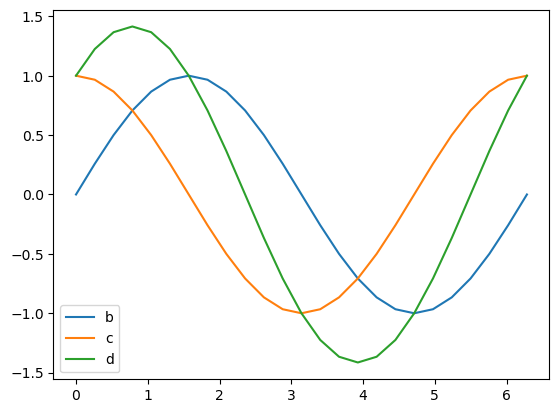

In [469]:
import math
import torch

import matplotlib.pyplot as plt

a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True) # leaf node
b = torch.sin(a)
b.retain_grad() # We need to call retrain_grad() explicitly here for a non-leaf node, as we won't get non-leaf gradients by default.
plt.plot(a.detach(), b.detach(), label="b")

c = torch.cos(a)
c.retain_grad()
plt.plot(a.detach(), c.detach(), label="c")

d = b + c
d.retain_grad()
plt.plot(a.detach(), d.detach(), label="d")
plt.legend()

out = d.sum() # root node
out.retain_grad()

The *computation graph* (a DAG) looks like:

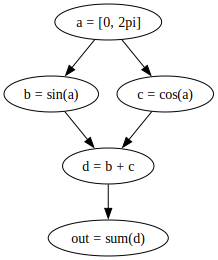

In [470]:
import graphviz
dot = graphviz.Digraph()
dot.node('a', 'a = [0, 2pi]')
dot.node('b', 'b = sin(a)')
dot.node('c', 'c = cos(a)')
dot.node('d', 'd = b + c')
dot.node('o', 'out = sum(d)')
dot.edges(['ab', 'ac', 'bd', 'cd', 'do'])
dot

## grad_fn, backward, and grad
The `grad_fn` is the local function, and its property `next_functions` backtrack its parent node(s) in the computation graph:

In [471]:
a.grad_fn

In [472]:
b.grad_fn

In [473]:
c.grad_fn

In [474]:
d.grad_fn

In [475]:
out.grad_fn

In [476]:
out.grad_fn.next_functions # only a single parent

((<AddBackward0 at 0x7ff08e2e1930>, 0),)

In [477]:
d.grad_fn.next_functions # two parents

((<SinBackward0 at 0x7ff08e07d450>, 0), (<CosBackward0 at 0x7ff08e070370>, 0))

In [478]:
d.grad_fn.next_functions[1][0].next_functions # right parent

((<AccumulateGrad at 0x7ff08e141f30>, 0),)

Before we get `grad`, we will need to "back propagate":

In [479]:
out.backward(retain_graph=True) # retain_graph=True keep this computation graph for us to call backward() again (see later)

In [480]:
print(a.grad)
print(b.grad)
print(c.grad)
print(d.grad)
print(out.grad)

tensor([ 1.0000e+00,  7.0711e-01,  3.6603e-01,  0.0000e+00, -3.6603e-01,
        -7.0711e-01, -1.0000e+00, -1.2247e+00, -1.3660e+00, -1.4142e+00,
        -1.3660e+00, -1.2247e+00, -1.0000e+00, -7.0711e-01, -3.6603e-01,
         2.3842e-07,  3.6603e-01,  7.0711e-01,  1.0000e+00,  1.2247e+00,
         1.3660e+00,  1.4142e+00,  1.3660e+00,  1.2247e+00,  1.0000e+00])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


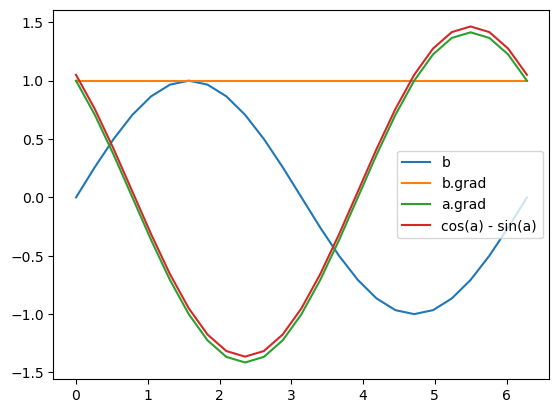

In [481]:
plt.plot(a.detach(), b.detach(), label="b")
plt.plot(a.detach(), b.grad.detach(), label="b.grad")
plt.plot(a.detach(), a.grad.detach(), label="a.grad")
eps = 0.05
plt.plot(a.detach(), torch.cos(a).detach() - torch.sin(a).detach() + eps, label="cos(a) - sin(a)")
plt.legend()

if we think via math equations:
$$
\begin{align}
\text{out} &= \sum_i d_i \\
d_i &= b_i + c_i \\
b_i &= \sin(a_i) \\
c_i &= \cos(a_i) \\
\end{align}
$$
therefore
$$
\begin{align}
\text{b[i].grad} &= \frac{\partial}{\partial b_i}\sum_{j}d_j = 1 \\
\text{a[i].grad} &=  1 \cdot \frac{\partial}{\partial a_i} (\sin a_i + \cos a_i) = \cos a_i - \sin a_i
\end{align}
$$

Note that we can also call `backward()` from an intermediate node:

In [482]:
# clear the accumulated gradients
a.grad.zero_()
b.grad.zero_()
c.grad.zero_()
d.grad.zero_()
out.grad.zero_()

tensor(0.)

In [483]:
d.backward(torch.ones(25))

We will get the same results:

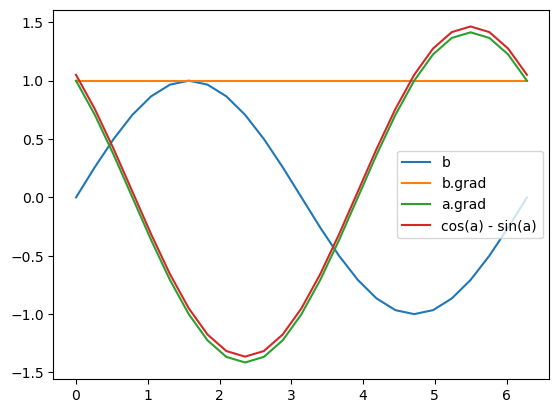

In [484]:
plt.plot(a.detach(), b.detach(), label="b")
plt.plot(a.detach(), b.grad.detach(), label="b.grad")
plt.plot(a.detach(), a.grad.detach(), label="a.grad")
eps = 0.05
plt.plot(a.detach(), torch.cos(a).detach() - torch.sin(a).detach() + eps, label="cos(a) - sin(a)")
plt.legend()

However, there is a minor difference: Because `out` node does not gets propogated this time, so its gradients is still zero for the last `backward()` call:

In [485]:
print(a.grad)
print(b.grad)
print(c.grad)
print(d.grad)
print(out.grad)

tensor([ 1.0000e+00,  7.0711e-01,  3.6603e-01,  0.0000e+00, -3.6603e-01,
        -7.0711e-01, -1.0000e+00, -1.2247e+00, -1.3660e+00, -1.4142e+00,
        -1.3660e+00, -1.2247e+00, -1.0000e+00, -7.0711e-01, -3.6603e-01,
         2.3842e-07,  3.6603e-01,  7.0711e-01,  1.0000e+00,  1.2247e+00,
         1.3660e+00,  1.4142e+00,  1.3660e+00,  1.2247e+00,  1.0000e+00])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.])
tensor(0.)
